# Capstone Project by Robert Whelan

## Expected Points Projection within Fantasy Premier League

## 1) The problem

Fantasy League as a concept is to select a squad of 15 players that will maximise the total points returned each game week based on many variables for scoring points. Each week the manager has to make decisions based on statistics and form an educated guess as to which players will be the best pick before the gameweek starts.

The problem therefore is to identify which variables are the most important to consider when making these predictions and the resulting question is can a model be built to incorporate these especially considering the unpredictable nature of football and sport in general?

Points can be scored from any of the follwing avenues:

| Action                                                  | Points |
|---------------------------------------------------------|--------|
| For playing up to 60 minutes                            | 1      |
| For playing 60 minutes or more (excluding stoppage time)| 2      |
| For each goal scored by a goalkeeper or defender        | 6      |
| For each goal scored by a midfielder                    | 5      |
| For each goal scored by a forward                       | 4      |
| For each goal assist                                    | 3      |
| For a clean sheet by a goalkeeper or defender           | 4      |
| For a clean sheet by a midfielder                       | 1      |
| For every 3 shot saves by a goalkeeper                  | 1      |
| For each penalty save                                   | 5      |
| For each penalty miss                                   | -2     |
| Bonus points for the best players in a match            | 1-3    |
| For every 2 goals conceded by a goalkeeper or defender  | -1     |
| For each yellow card                                    | -1     |
| For each red card                                       | -3     |
| For each own goal                                       | -2     |

With this in mind the project aim will be to create a dataset that considers all these variables and additionally any related variables that could be used in predicting these results.

## 2) The data

The Fantasy Premier League website has an API directly available via 'https://fantasy.premierleague.com/api/bootstrap-static/' however the data is only for the current season. This analysis will be performed over an entire season to maximise the size of the database. Therefore an alternative source is required to obtain the fantasy premier league statistics for the previous season 2021/2022.

The following github link provides all the data required and is freely available/public: https://github.com/vaastav/Fantasy-Premier-League/tree/master/data

Within this github databank is data extracted directly from the premier league website for the required season but also additonal data that has been scraped from Understat. The Premier League dataset only tracks the variables that directly lead to points such as (and shown in the list above):

- Goals scored
- Goals conceded
- Assists
- Yellow cards
- Red cards

Whilst all these metrics will be essential for the following analysis, they do not capture the full picture. Understat data contains many other variables that can offer insights into a player's performance that did not directly lead to points being scored such as:

- xG
- Shots
- xA
- Key passes
- xGBuildup

Expected goals, expected assists and other variables can highlight how involved a player has been within a game without necessarily achieving points and these can be used as predictors for future results.

The final element of the data will be the equivalent analysis on the teams that each player plays for and the opposition they will face. This will be captured within the Understat team database.

*FPL Player Dataset*

In [1]:
# load required libraries
import numpy as np
import pandas as pd
import glob
import os 

# increase column display
pd.set_option('display.max_columns', None)

# combine all files in the following directory
fpl_files = glob.glob(os.path.join("C:\\Users\\Rob\\Documents\\GitHub\\Fantasy-Premier-League\\data\\2021-22\\Players\\*", "gw.csv"))

This collection of files combines all player's individual performances across the entire season.

The identity of each player is providedd by the filename but not within the dataset so I will add this as a new column when combining the files.

In [2]:
# build dataset from all files adding in a column for filename
df_fpl = pd.concat((pd.read_csv(f).assign(filename=f) for f in fpl_files), ignore_index=True)

In [3]:
# review data
df_fpl.head(3)

,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,filename
0,0,0,0,0,0.0,72,2,0,0,0.0,0.0,2021-08-14T14:00:00Z,0,5,0,0,0,0,1,0,15789,2,1,0.0,0,0,0,0,55,False,0,C:\Users\Rob\Documents\GitHub\Fantasy-Premier-...
1,0,0,-2,0,1.1,72,12,0,0,0.5,0.0,2021-08-21T16:30:00Z,45,18,0,0,0,0,2,0,15599,0,2,6.0,1,-1682,1899,3581,55,True,0,C:\Users\Rob\Documents\GitHub\Fantasy-Premier-...
2,0,0,0,0,0.0,72,22,0,0,0.0,0.0,2021-08-28T14:00:00Z,0,8,0,0,0,0,3,0,15457,2,0,0.0,0,-737,2897,3634,55,True,0,C:\Users\Rob\Documents\GitHub\Fantasy-Premier-...


Filename column now needs to be filtered into a player name/id format for clarity

In [4]:
# increase display width to review example
pd.options.display.max_colwidth = 150

# review filename format
df_fpl['filename'].head(1)

0    C:\Users\Rob\Documents\GitHub\Fantasy-Premier-League\data\2021-22\Players\Aaron_Connolly_72\gw.csv
Name: filename, dtype: object

In [5]:
# player name/id is the 9th element of a split by \
df_fpl['player_name_id'] = df_fpl['filename'].str.split("\\", expand=True)[9]

# review
df_fpl['player_name_id'].head(1)

0    Aaron_Connolly_72
Name: player_name_id, dtype: object

Now that we have the new column can remove the filename column

In [6]:
# drop filename column
df_fpl = df_fpl.drop('filename', axis=1)

Player name ID column is useful however we also need to split out the FPL ID for future use

In [7]:
# import reg expression library to identity the number IDs
import re

# create empty list to add each ID to
idx = []

# iterate over each item within the column and add identified ID to idx
for x in df_fpl['player_name_id']:
    number = re.findall(r'\d+', x)[-1]  # re finding any full number
    idx.append(number)

# create new column of rows
df_fpl['fpl_id'] = idx

# change dtype
df_fpl['fpl_id'] = df_fpl['fpl_id'].astype(str)

Now to look at full database

In [8]:
# view size of dataset
df_fpl.shape

(25447, 33)

In [9]:
# view data types
df_fpl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25447 entries, 0 to 25446
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   assists            25447 non-null  int64  
 1   bonus              25447 non-null  int64  
 2   bps                25447 non-null  int64  
 3   clean_sheets       25447 non-null  int64  
 4   creativity         25447 non-null  float64
 5   element            25447 non-null  int64  
 6   fixture            25447 non-null  int64  
 7   goals_conceded     25447 non-null  int64  
 8   goals_scored       25447 non-null  int64  
 9   ict_index          25447 non-null  float64
 10  influence          25447 non-null  float64
 11  kickoff_time       25447 non-null  object 
 12  minutes            25447 non-null  int64  
 13  opponent_team      25447 non-null  int64  
 14  own_goals          25447 non-null  int64  
 15  penalties_missed   25447 non-null  int64  
 16  penalties_saved    254

Data completeleness looks good with no missing values. However, need to look into to make sure all variables are correct and information isnt missing.

The above dataset has many variables that are created independently by the website that are index based values. As we are not aware of the index and will look to be building our own performance snapshots, I will remove these variables from the datasest.

I will also remove any additional variables that do not provide insights to the players performance such as any "transfer" information that relates to the game.

In [10]:
# review mentioned columns
df_fpl[['bps', 'creativity', 'element', 'ict_index', 'influence', 'selected', 'threat', 'transfers_balance', 'transfers_in', 'transfers_out', 'value']].head(5)

,bps,creativity,element,ict_index,influence,selected,threat,transfers_balance,transfers_in,transfers_out,value
0,0,0.0,72,0.0,0.0,15789,0.0,0,0,0,55
1,-2,1.1,72,0.5,0.0,15599,6.0,-1682,1899,3581,55
2,0,0.0,72,0.0,0.0,15457,0.0,-737,2897,3634,55
3,0,0.0,72,0.0,0.0,12065,0.0,-3682,1857,5539,54
4,0,0.0,72,0.0,0.0,9659,0.0,-2548,301,2849,54


In [11]:
# drop columns from datasets
df_fpl = df_fpl.drop(['bps', 'creativity', 'element', 'ict_index', 'influence', 'selected', 'threat', 'transfers_balance', 'transfers_in', 'transfers_out', 'value'], axis=1)

In [12]:
# review remaining numerical data statistics
df_fpl.describe().loc[['mean', 'std']]

,assists,bonus,clean_sheets,fixture,goals_conceded,goals_scored,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,team_a_score,team_h_score,total_points,yellow_cards
mean,0.036507,0.095886,0.094825,198.967698,0.462962,0.040751,29.452116,10.494164,0.001336,0.000747,0.000472,0.001690,21.018784,0.088183,1.310528,1.507486,1.234487,0.050929
std,0.204397,0.463730,0.292978,108.684111,0.954906,0.219746,39.847840,5.763593,0.036529,0.027315,0.021711,0.041073,11.171262,0.605527,1.267124,1.321892,2.451813,0.219858


From above the columns that stand out are "minutes" and "fixture"/"opponent_team"/"round":
- Opponent_team, fixture and Round are categorical indicators of teams and gameweeks so need to be relabelled appropriately.
- Minutes stands out as there are 90 minutes in a game of football. An average that low would suggest there is a lot of player data that has no statistical significance (didn't participate in game)

In [13]:
# change data types
df_fpl[['fixture', 'opponent_team', 'round']] = df_fpl[['fixture', 'opponent_team', 'round']].astype(str)

Review graphically the assumption on minutes

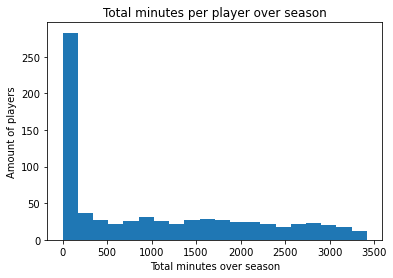

In [14]:
# import libraries
%matplotlib inline
import matplotlib.pyplot as plt 

# build histogram of minutes played grouped by player
plt.hist(df_fpl.groupby('player_name_id')['minutes'].sum(), bins=20)
plt.title("Total minutes per player over season")
plt.xlabel("Total minutes over season")
plt.ylabel("Amount of players")
plt.show()

Based on above clear that data includes many "reserve" players that play either very limited or no games during the season. I will now identify these players and review statistical profile compared to rest of the database.

In [15]:
# create a reserves group
reserves = []

# iterate over all the unique player name ids and retrieve all players that have less than 450 minutes played (< 5 games)
for player in df_fpl['player_name_id'].unique():
    # create individual dataframes
    df_sum = df_fpl[df_fpl['player_name_id']==player]
    
    # calculate mins played of each player
    mins_played = df_sum['minutes'].sum()
    
    # add plyer name to the reserves group if sum of mins is sub 450 (ie 5 games)
    if mins_played < 450:
        reserves.append(player)

In [16]:
# view the quantity of players in reserves group
print("Total players inc reserves:", (len(df_fpl['player_name_id'].unique())))
print("Total reserve players:", len(np.unique(reserves)))

Total players inc reserves: 737
Total reserve players: 340


Review the data for the reserves

In [17]:
# create function to build identifier column
def is_reserve(x):
    if x in reserves:
        return "reserve"
    else:
        return "player"
    
# apply function to player column creating label    
df_fpl['reserve_player'] = df_fpl['player_name_id'].apply(lambda x: is_reserve(x))

Now we have an identifier we can compare statistical profiles of the two sets of players

In [18]:
# groupby the label and review most important stats for scoring poitns
df_fpl.groupby('reserve_player')[['minutes', 'assists', 'goals_scored', 'goals_conceded']].describe()

minutes                                                    \
                  count       mean        std  min  25%   50%   75%   max   
reserve_player                                                              
player          14818.0  49.115063  41.311769  0.0  0.0  68.0  90.0  90.0   
reserve         10629.0   2.039797  11.480188  0.0  0.0   0.0   0.0  90.0   

                assists                                               \
                  count      mean       std  min  25%  50%  75%  max   
reserve_player                                                         
player          14818.0  0.061479  0.262244  0.0  0.0  0.0  0.0  4.0   
reserve         10629.0  0.001693  0.045466  0.0  0.0  0.0  0.0  2.0   

               goals_scored                                               \
                      count      mean       std  min  25%  50%  75%  max   
reserve_player                                                             
player              14818.0  0.068228  0.281247  0.0  0.0  0.0  0.0  4.0   
reserve             10629.0  0.002446  0.053073  0.0  0.0  0.0  0.0  2.0   

               goals_conceded                                               
                        count      mean       std  min  25%  50%  75%  max  
reserve_player                                                              
player                14818.0  0.764543  1.131661  0.0  0.0  0.0  1.0  7.0  
reserve               10629.0  0.042525  0.306862  0.0  0.0  0.0  0.0  5.0

As expected, we can see there is a significant difference between the relevance of the two sets of data. The Reserves minutes played mean is 2 mins compared to the players at 49mins and the contribution towards goals and assists is close to zero. Considering this it seems reasonable to remove the reserves from the dataset as offer little statistical significance.

In [19]:
# remove reserve players
mask = df_fpl['player_name_id'].isin(reserves)  # create mask

df_fpl = df_fpl[~mask] # remove mask players

In [20]:
# drop reserve player column
df_fpl = df_fpl.drop('reserve_player', axis=1)

FPL dataset is now ready to use. Moving on to the second dataset from Understat.

*Understat Dataset*

Similarly to FPL data need to combine all files within the player folder to access all player data

In [21]:
# build all player library
all_players = glob.glob(os.path.join("C:\\Users\\Rob\\Documents\\GitHub\\Fantasy-Premier-League\\data\\2021-22\\understat\\Players", "*.csv"))

In [22]:
# assign filenames on to file combination dataset
df_u = pd.concat((pd.read_csv(f).assign(filename=f) for f in all_players), ignore_index=True)

In [23]:
# review dataset
df_u.head(3)

,goals,shots,xG,time,position,h_team,a_team,h_goals,a_goals,date,id,season,roster_id,xA,assists,key_passes,npg,npxG,xGChain,xGBuildup,filename
0,0,0,0.000000,64,FW,Brighton,Wolverhampton Wanderers,0,1,2021-12-15,16538,2021,503282,0.000000,0,0,0,0.000000,0.000000,0.0,C:\Users\Rob\Documents\GitHub\Fantasy-Premier-League\data\2021-22\understat\Players\Aaron_Connolly_7991.csv
1,0,1,0.036493,34,Sub,Southampton,Brighton,1,1,2021-12-04,16521,2021,499911,0.380411,0,1,0,0.036493,0.416904,0.0,C:\Users\Rob\Documents\GitHub\Fantasy-Premier-League\data\2021-22\understat\Players\Aaron_Connolly_7991.csv
2,0,0,0.000000,12,Sub,Crystal Palace,Brighton,1,1,2021-09-27,16435,2021,486003,0.000000,0,0,0,0.000000,0.000000,0.0,C:\Users\Rob\Documents\GitHub\Fantasy-Premier-League\data\2021-22\understat\Players\Aaron_Connolly_7991.csv


In [24]:
# review filename format
df_u['filename'].head(1)

0    C:\Users\Rob\Documents\GitHub\Fantasy-Premier-League\data\2021-22\understat\Players\Aaron_Connolly_7991.csv
Name: filename, dtype: object

In [25]:
# clean up filename including removal of .csv
df_u['player_name_id'] = df_u['filename'].str.split("\\", expand=True)[10].str.split(".csv", expand=True)[0]

# drop filename columns
df_u = df_u.drop('filename', axis=1)

In [26]:
# create empty list to add each ID to
idx = []

# iterate over each item within the column and add identified ID to idx
for x in df_u['player_name_id']:
    number = re.findall(r'\d+', x)[-1]  # re finding any full number
    idx.append(number)

# create new column of rows
df_u['ustat_id'] = idx

# change dtype
df_u['ustat_id'] = df_u['ustat_id'].astype(str)

Overview of dataset

In [27]:
df_u.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70102 entries, 0 to 70101
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   goals           70102 non-null  int64  
 1   shots           70102 non-null  int64  
 2   xG              70102 non-null  float64
 3   time            70102 non-null  int64  
 4   position        70102 non-null  object 
 5   h_team          70102 non-null  object 
 6   a_team          70102 non-null  object 
 7   h_goals         70102 non-null  int64  
 8   a_goals         70102 non-null  int64  
 9   date            70102 non-null  object 
 10  id              70102 non-null  int64  
 11  season          70102 non-null  int64  
 12  roster_id       70102 non-null  int64  
 13  xA              70102 non-null  float64
 14  assists         70102 non-null  int64  
 15  key_passes      70102 non-null  int64  
 16  npg             70102 non-null  int64  
 17  npxG            70102 non-null 

As we can see the Dataset includes similar data plus all the additional parameters necessary to build player profiles. 

Start by removing the columns that are already included in FPL dataset and other unnecessary variables.

N.B. Reason for keeping the FPL version of this data is because the model will be predicting fantasy league points and therefore needs to be correlated with that dataset output.

In [28]:
# drop mentioned variables
df_u = df_u.drop(['goals', 'position', 'roster_id', 'assists'], axis=1)

In [29]:
# review size of database
df_u.shape

(70102, 18)

Understat dataset contains nearly 3x as much data. Need to identify where the additional info is.

In [30]:
# review which time period the data runs through
df_u['date'].sort_values()

60372    2014-08-02
19169    2014-08-08
41022    2014-08-08
41266    2014-08-08
64691    2014-08-08
            ...    
3242     2022-05-22
59827    2022-05-22
65846    2022-05-22
23882    2022-05-22
54056    2022-05-22
Name: date, Length: 70102, dtype: object

As we can see above, the data contains additional seasons for each player. As this is out of scope for this analysis will go ahead and remove previous seasons. 

In [31]:
# filter by required season
df_u = df_u[df_u['season']==2021]

Databse sizes should now be a lot closer

In [32]:
print(df_fpl.shape)
print(df_u.shape)

(14818, 22)
(10957, 18)


Display minutes played by each player within this databse

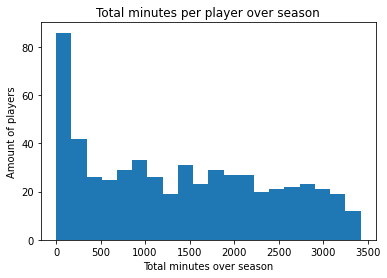

In [33]:
# review minutes plot for ustat data
plt.hist(df_u.groupby('player_name_id')['time'].sum(), bins=20)
plt.title("Total minutes per player over season")
plt.xlabel("Total minutes over season")
plt.ylabel("Amount of players")
plt.show()

Suggests far fewer players with small amount of minutes so no need to remove "reserves". I will also only be using the data within this dataset for the players remaining in the FPL dataset.

*Missing information*

Two important bits of information missing from the player datasets:
- Player's team
- Player's position

This information is available from alternative files.

**Teamname**

Teamname information is available within the ustat database

In [34]:
# import summary file
ustat_summary = pd.read_csv(r"C:\\Users\\Rob\\Documents\\GitHub\\Fantasy-Premier-League\\data\\2021-22\\understat\\understat_player.csv")

# view top entries
ustat_summary.head()

,id,player_name,games,time,goals,xG,assists,xA,shots,key_passes,yellow_cards,red_cards,position,team_title,npg,npxG,xGChain,xGBuildup
0,453,Son Heung-Min,35,3051,23,16.992174,7,7.846954,86,73,2,0,F M,Tottenham,23,16.992174,29.624776,10.343093
1,1250,Mohamed Salah,35,2757,23,24.364297,13,9.790820,139,62,1,0,F S,Liverpool,18,19.797284,32.158807,11.221982
2,2371,Cristiano Ronaldo,30,2468,18,17.212840,3,4.424966,110,26,8,0,F S,Manchester United,15,14.929333,23.253713,7.720640
3,647,Harry Kane,37,3229,17,20.685065,9,9.818288,133,48,5,0,F M S,Tottenham,13,17.640390,31.892183,9.808406
4,838,Sadio Mané,34,2833,16,16.829614,2,5.269159,98,39,5,0,F S,Liverpool,16,16.829614,28.448094,11.072970


This database includes a column for each player's team name and we can link together based on the ustat ID.

In [35]:
# update dtype
ustat_summary['id'] = ustat_summary['id'].astype(str) 

# build a dictionary of id and team values
id_team_dict = {under: team for under, team in zip(ustat_summary['id'], ustat_summary['team_title'])}

# apply dict with map to original database
df_u['team_name'] = df_u['ustat_id'].map(id_team_dict)

In [36]:
# review
df_u.head(3)

,shots,xG,time,h_team,a_team,h_goals,a_goals,date,id,season,xA,key_passes,npg,npxG,xGChain,xGBuildup,player_name_id,ustat_id,team_name
0,0,0.000000,64,Brighton,Wolverhampton Wanderers,0,1,2021-12-15,16538,2021,0.000000,0,0,0.000000,0.000000,0.0,Aaron_Connolly_7991,7991,Brighton
1,1,0.036493,34,Southampton,Brighton,1,1,2021-12-04,16521,2021,0.380411,1,0,0.036493,0.416904,0.0,Aaron_Connolly_7991,7991,Brighton
2,0,0.000000,12,Crystal Palace,Brighton,1,1,2021-09-27,16435,2021,0.000000,0,0,0.000000,0.000000,0.0,Aaron_Connolly_7991,7991,Brighton


**Position**

Position information is available (and needs to match) FPL database as is directly linked to the points each player scores.

In [37]:
# import data
players_posn = pd.read_csv(r"C:\\Users\\Rob\\Documents\\GitHub\\Fantasy-Premier-League\\data\\2021-22\\players_raw.csv")

# review data
players_posn.head(3)

,assists,bonus,bps,chance_of_playing_next_round,chance_of_playing_this_round,clean_sheets,code,corners_and_indirect_freekicks_order,corners_and_indirect_freekicks_text,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,creativity,creativity_rank,creativity_rank_type,direct_freekicks_order,direct_freekicks_text,dreamteam_count,element_type,ep_next,ep_this,event_points,first_name,form,goals_conceded,goals_scored,ict_index,ict_index_rank,ict_index_rank_type,id,in_dreamteam,influence,influence_rank,influence_rank_type,minutes,news,news_added,now_cost,own_goals,penalties_missed,penalties_order,penalties_saved,penalties_text,photo,points_per_game,red_cards,saves,second_name,selected_by_percent,special,squad_number,status,team,team_code,threat,threat_rank,threat_rank_type,total_points,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,web_name,yellow_cards
0,0,0,69,100,100,1,80201,None,NaN,0,0,-5,5,0.0,614,69,None,NaN,1,1,1.0,1.0,0,Bernd,0.0,9,0,8.5,442,30,1,False,85.0,400,29,360,NaN,2022-02-11T08:00:15.144286Z,45,0,0,None,0,NaN,80201.jpg,2.5,0,10,Leno,0.8,False,None,a,1,3,0.0,598,60,10,80974,0,205566,0,0.0,2.2,Leno,0
1,0,0,0,0,0,0,115918,None,NaN,0,0,0,0,0.0,523,34,None,NaN,0,1,0.0,0.0,0,Rúnar Alex,0.0,0,0,0.0,541,55,2,False,0.0,537,55,0,Joined OH Leuven on a season-long loan - Expected back 01 Jul,2021-08-31T22:00:09.069158Z,40,0,0,None,0,NaN,115918.jpg,0.0,0,0,Rúnarsson,0.5,False,None,u,1,3,0.0,490,19,0,19017,0,81363,0,0.0,0.0,Rúnarsson,0
2,0,0,0,0,0,0,47431,None,NaN,0,0,-2,2,0.0,733,307,None,NaN,0,3,0.0,0.0,0,Willian,0.0,0,0,0.0,733,307,3,False,0.0,733,307,0,Transferred to Corinthians,2021-08-20T09:30:14.065783Z,63,0,0,None,0,NaN,47431.jpg,0.0,0,0,Borges Da Silva,0.1,False,None,u,1,3,0.0,733,307,0,914,0,20541,0,0.0,0.0,Willian,0


Position identified within this database as the "element_type" with numerical formatting. Element types are as follows 1 = GK, 2 = DEF, 3 = MID, 4 = FWD.

In [38]:
# ensure id is in correct format
players_posn['id'] = players_posn['id'].astype(str)

# create dictionary
posn_dict = {idx: posn for idx, posn in zip(players_posn['id'], players_posn['element_type'])}

# apply to fpl data to create new column
df_fpl['position'] = df_fpl['fpl_id'].map(posn_dict)

# create new dictionary for correct labels
posn_labels = {1 : 'gk', 2 : 'def', 3 : 'mid', 4 : 'fwd'}

# update positioning based on labels
df_fpl['position'] = df_fpl['position'].map(posn_labels)

*Combining the two player Databases*

First step to combining the two databases is to create a linking ID databse. Github source includes an ID mapping dictionary file.

In [39]:
# import file
player_id = pd.read_csv(r"C:\\Users\\Rob\\Documents\\GitHub\\Fantasy-Premier-League\\data\\2021-22\\id_dict.csv")

# review format
player_id.head(3)

,Understat_ID,FPL_ID,Understat_Name,FPL_Name
0,62,317,Lukas Rupp,Lukas Rupp
1,65,134,Timo Werner,Timo Werner
2,76,305,Fabian Schär,Fabian Schär


In [40]:
# update dtypes to match fpl id 
player_id[[' FPL_ID', 'Understat_ID']] = player_id[[' FPL_ID', 'Understat_ID']].astype(str)

# create a dictionary to use 
id_dict = {fpl: under for fpl, under in zip(player_id[' FPL_ID'], player_id['Understat_ID'])}

# apply to fpl data to create new column
df_fpl['under_id'] = df_fpl['fpl_id'].map(id_dict)

# confirm mapped correctly
df_fpl.head(3)

,assists,bonus,clean_sheets,fixture,goals_conceded,goals_scored,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,team_a_score,team_h_score,total_points,was_home,yellow_cards,player_name_id,fpl_id,position,under_id
38,0,0,0,9,2,1,2021-08-15T13:00:00Z,90,14,0,0,0,0,1,0,4,2,7,False,0,Aaron_Cresswell_411,411,def,534
39,0,0,0,20,1,0,2021-08-23T19:00:00Z,90,9,0,0,0,0,2,0,1,4,2,True,0,Aaron_Cresswell_411,411,def,534
40,1,1,0,28,2,0,2021-08-28T14:00:00Z,90,7,0,0,0,0,3,0,2,2,5,True,0,Aaron_Cresswell_411,411,def,534


Now that we have a link between the two datasets need a link to connect the individual games. The easiest way to do this is by using the "date" of each game.

The FPL database shows indivdual date, however ustat the date is within the kickoff column. This will need to be split out first.

In [41]:
# review format
df_fpl['kickoff_time'].head(1)

38    2021-08-15T13:00:00Z
Name: kickoff_time, dtype: object

In [42]:
# split value at "T" and select the expanded first value to create new column date
df_fpl['date'] = df_fpl['kickoff_time'].str.split("T", expand=True)[0]

Now that we have IDs and a way to link each individual game now look to merge the two databases

In [43]:
# create new variable to add each player's data too
data = []

# iterate over each player, selecting subset of each player and merging datasets based on the date values
for x in df_fpl['under_id'].unique():
    
    # create subset
    new_df = df_fpl[df_fpl['under_id']==x]
        
    # merge with understat data
    merge = new_df.merge(df_u[df_u['ustat_id']==x], left_on='date', right_on='date', how='outer', indicator=True)  # add indicator to highlight any that havent worked on both
    
    # add merged data to new variables
    data.append(merge)

# build a new dataframe of all the merged datasets
df_all = pd.concat(data)

In [44]:
# review shapes to see if merge has worked
print(df_fpl.shape)
print(df_all.shape)

# review data
df_all.head(3)

(14818, 25)
(14982, 44)


,assists,bonus,clean_sheets,fixture,goals_conceded,goals_scored,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,team_a_score,team_h_score,total_points,was_home,yellow_cards,player_name_id_x,fpl_id,position,under_id,date,shots,xG,time,h_team,a_team,h_goals,a_goals,id,season,xA,key_passes,npg,npxG,xGChain,xGBuildup,player_name_id_y,ustat_id,team_name,_merge
0,0.0,0.0,0.0,9,2.0,1.0,2021-08-15T13:00:00Z,90.0,14,0.0,0.0,0.0,0.0,1,0.0,4.0,2.0,7.0,False,0.0,Aaron_Cresswell_411,411,def,534,2021-08-15,2.0,0.082975,90.0,Newcastle United,West Ham,2.0,4.0,16384.0,2021.0,0.037909,1.0,1.0,0.082975,0.544756,0.499803,Aaron_Cresswell_534,534,West Ham,both
1,0.0,0.0,0.0,20,1.0,0.0,2021-08-23T19:00:00Z,90.0,9,0.0,0.0,0.0,0.0,2,0.0,1.0,4.0,2.0,True,0.0,Aaron_Cresswell_411,411,def,534,2021-08-23,1.0,0.049394,90.0,West Ham,Leicester,4.0,1.0,16395.0,2021.0,0.000000,0.0,0.0,0.049394,0.223798,0.223798,Aaron_Cresswell_534,534,West Ham,both
2,1.0,1.0,0.0,28,2.0,0.0,2021-08-28T14:00:00Z,90.0,7,0.0,0.0,0.0,0.0,3,0.0,2.0,2.0,5.0,True,0.0,Aaron_Cresswell_411,411,def,534,2021-08-28,0.0,0.000000,90.0,West Ham,Crystal Palace,2.0,2.0,16401.0,2021.0,0.092539,1.0,0.0,0.000000,0.307552,0.215013,Aaron_Cresswell_534,534,West Ham,both


Review data that has been "added" by reviewing "_merge" column. 

In [45]:
# FPL data displays rows for every game that a player's team played. ustat only displays games where player's participated
# sum of minutes for left only merge
df_all[df_all['_merge']=='left_only']['minutes'].sum()

0.0

As not possible to go through and comment on each individual player reason for not playing in that game (injury, not picked, away) going to remove from the data.

In [46]:
# create mask and remove entries
mask = df_all['_merge']=='left_only'
print(df_all.shape)

df_all = df_all[~mask]
print(df_all.shape)

(14982, 44)
(10077, 44)


In [47]:
# right only data lets look at players involved 
df_all[df_all['_merge']=='right_only']['player_name_id_y'].unique()

array(['Adama_Traoré_900', 'Axel_Tuanzebe_934', 'Bruno_Guimarães_8327',
       'Cristiano_Ronaldo_2371', 'Dejan_Kulusevski_6691', 'Emerson_7430',
       'Hassane_Kamara_3729', 'Hee-Chan_Hwang_8845',
       'Marc_Cucurella_7134', 'Mathias_Normann_7470',
       'Maxwel_Cornet_3278', 'Nikola_Vlasic_6276',
       'Philippe_Coutinho_488', 'Pierre-Emerick_Aubameyang_318',
       'Rodrigo_Bentancur_6108', 'Samir_1142', 'Saúl_Ñíguez_2266',
       'Takehiro_Tomiyasu_7931', 'Tanguy_NDombele_Alvaro_5962',
       'Wout_Weghorst_7052'], dtype=object)

Looking at all the player names in the right only, these were all players signed mid season from teams in different leagues. As the "unmatched" data relates to games played abroad this is outside scope and can be removed.

In [48]:
# confirm teams
df_all[df_all['_merge']=='right_only']['h_team'].unique()

array(['Barcelona', 'Levante', 'Real Madrid', 'Elche', 'Napoli', 'Lyon',
       'Troyes', 'Lille', 'Bordeaux', 'Montpellier', 'Rennes', 'Nice',
       'Saint-Etienne', 'Paris Saint Germain', 'Nantes', 'Angers',
       'Udinese', 'AC Milan', 'Juventus', 'Roma', 'Bologna',
       'Salernitana', 'Lazio', 'Verona', 'Inter', 'Torino', 'Spezia',
       'Athletic Club', 'Clermont Foot', 'RasenBallsport Leipzig',
       'Mainz 05', 'Valencia', 'Ural', 'Nizhny Novgorod', 'FC Rostov',
       'Khimki', 'Zenit St. Petersburg', 'CSKA Moscow', 'Dinamo Moscow',
       'Osasuna', 'Villarreal', 'Rayo Vallecano', 'Atletico Madrid',
       'Cadiz', 'Getafe', 'Real Betis', 'Real Sociedad', 'Espanyol',
       'Venezia', 'Cagliari', 'Empoli', 'Atalanta', 'Sampdoria',
       'Celta Vigo', 'Metz', 'Strasbourg', 'Monaco', 'Wolfsburg',
       'Bochum', 'Bayern Munich', 'Arminia Bielefeld', 'Union Berlin',
       'Hoffenheim', 'Greuther Fuerth', 'Hertha Berlin'], dtype=object)

In [49]:
# create mask and remove entries
mask = df_all['_merge']=='right_only'
print(df_all.shape)
df_all = df_all[~mask]
print(df_all.shape)

(10077, 44)
(9913, 44)


Drop any further values that contain teams out of scope

In [50]:
# create mask and remove entries
mask = ~df_all['h_team'].isin(df_all['team_name'].unique())
print(df_all.shape)

df_all = df_all[~mask]
print(df_all.shape)

(9913, 44)
(9899, 44)


*Team Understat Data*

In [51]:
# create list of all team name files
all_teams = glob.glob(os.path.join("C:\\Users\\Rob\\Documents\\GitHub\\Fantasy-Premier-League\\data\\2021-22\\understat\\Teams", "*.csv"))

# create dataframe with all filnames assigned
df_teams = pd.concat((pd.read_csv(f).assign(filename=f) for f in all_teams), ignore_index=True)

In [52]:
df_teams['filename'].head(1)

0    C:\Users\Rob\Documents\GitHub\Fantasy-Premier-League\data\2021-22\understat\Teams\understat_Arsenal.csv
Name: filename, dtype: object

In [53]:
# extract team name from filename
df_teams['team_name'] = df_teams['filename'].str.split("\\", expand=True)[10].str.split(".csv", expand=True)[0].str.split("understat_", expand=True)[1]

# replace underscore with space to match other dataset
df_teams['team_name'] = df_teams['team_name'].str.replace("_", " ")

In [54]:
# review data
df_teams.head(3)

,h_a,xG,xGA,npxG,npxGA,ppda,ppda_allowed,deep,deep_allowed,scored,missed,xpts,result,date,wins,draws,loses,pts,npxGD,filename,team_name
0,a,1.023850,1.88818,1.023850,1.88818,"{'att': 127, 'def': 22}","{'att': 290, 'def': 18}",10,7,0,2,0.6559,l,2021-08-13 19:00:00,0,0,1,0,-0.864330,C:\Users\Rob\Documents\GitHub\Fantasy-Premier-League\data\2021-22\understat\Teams\understat_Arsenal.csv,Arsenal
1,h,0.630099,3.64132,0.630099,3.64132,"{'att': 376, 'def': 23}","{'att': 156, 'def': 15}",3,19,0,2,0.0659,l,2021-08-22 15:30:00,0,0,1,0,-3.011221,C:\Users\Rob\Documents\GitHub\Fantasy-Premier-League\data\2021-22\understat\Teams\understat_Arsenal.csv,Arsenal
2,a,0.116805,4.47273,0.116805,4.47273,"{'att': 365, 'def': 7}","{'att': 91, 'def': 18}",0,14,0,5,0.0063,l,2021-08-28 11:30:00,0,0,1,0,-4.355925,C:\Users\Rob\Documents\GitHub\Fantasy-Premier-League\data\2021-22\understat\Teams\understat_Arsenal.csv,Arsenal


In [55]:
# drop unnecessary columns
df_teams = df_teams.drop(['ppda', 'ppda_allowed', 'deep', 'deep_allowed', 'xpts', 'wins', 'draws', 'loses', 'filename'], axis=1)

In [56]:
# split date column into required format
df_teams['date'] = df_teams['date'].str.split(expand=True)[0]

In [57]:
# review shape
df_teams.shape

(874, 12)

Should only be 760 rows within the data (20 teams x 19 games x2). Dataset again needs older team data removed.

In [58]:
# convert dataetime format
df_teams['date'] = pd.to_datetime(df_teams['date'])

df_all['date'] = pd.to_datetime(df_all['date'])

# build mask of previous seasons
mask = df_teams['date'] < '2021-08-13'

# remove
df_teams = df_teams[~mask]

# verify shape
df_teams.shape

**Missing Data**

Team data does not include goals conceded or round. Create database using ustat player data from df_all

In [59]:
# create required fields
conceded = []
teamname = []
num_round = []

# iterate over each of the was home columns 
for count, x in enumerate(df_all['was_home']):   
    
    # if x is True ie team was home append following
    if x == True:
        conceded.append(df_all['a_goals'].iloc[count])
        teamname.append(df_all['h_team'].iloc[count])
        num_round.append(df_all['round'].iloc[count])
    
    # if x is False ie team was away append following
    elif x == False:
        conceded.append(df_all['h_goals'].iloc[count])
        teamname.append(df_all['a_team'].iloc[count]) 
        num_round.append(df_all['round'].iloc[count])        
        

# add to player database        
df_all['conceded'] = conceded
df_all['teamname'] = teamname
df_all['num_round'] = num_round

Use these new columns to build a "team" key version

In [60]:
# filter columns required 
team_add = df_all[['teamname', 'date', 'num_round', 'conceded']]

# drop dupes as only need unique team value 
team_add = team_add.drop_duplicates()

# sort values
team_add = team_add.sort_values(by=['teamname', 'date'])

team_add.head()

,teamname,date,num_round,conceded
0,Arsenal,2021-08-13,1,2.0
1,Arsenal,2021-08-22,2,2.0
2,Arsenal,2021-08-28,3,5.0
2,Arsenal,2021-09-11,4,0.0
3,Arsenal,2021-09-18,5,0.0


Add new column for team conceded/rounds

In [61]:
df_teams['conceded'] = team_add['conceded'].values
df_teams['num_round'] = team_add['num_round'].values

**Preliminary Team EDA**

One of the key elements required for this analysis is the concept of "form". Traditional models and players typically look at mostly achieved stats for predicting future outputs. However, what the next analysis will hopefully confirm is that looking at more recent data over last 5 games can also be useful.

It is easier to build a team's form profile before combining with the player data, however in the EDA section later will go into more detail on explanation.

In [62]:
# filter variables that form guide will be built for 
variables = ['xG', 'xGA', 'scored', 'missed', 'conceded', 'pts']

# build summary 
summary = []

# iterate over all the teams within the teams database
for x in df_teams['team_name'].unique():
    
    # filter data for that team
    team_overview = df_teams[df_teams['team_name']==x]
    
    r = []
    d = []
    
    # for each variable build new columns of rolling 5 game averages and the differences of the averages
    for y in variables:
        
        rolling = team_overview[y].rolling(window=5, axis=0).mean()
        diff = rolling.diff()
        
        r.append(rolling)
        d.append(diff)
      
    # combine all the data for each team
    r_combo = pd.concat(r, axis=1)
    d_combo = pd.concat(d, axis=1)
    
    # combine the two
    combo = pd.concat([r_combo, d_combo], axis=1)
    
    # add full data into summary
    summary.append(combo)

# create column names for rolling and differences    
variables = ['rolling_team_' + var for var in variables] + ['diff_team_' + var for var in variables]    

# combine summary & rename columns 
team_sum = pd.concat(summary)
team_sum.columns = variables

# add to teams database
df_teams[variables] = team_sum

The reason to create form is to consider the fact that teams go through "dips" in form as well as "hot" streaks. The attempt with 5 game rolling data is to capture this in the data.

We can now view this graphically.

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt

# create function that compares teams

def team_comparison(variable, team_1, team_2, team_3):
    
    # build individual team databases
    df_1 = df_teams[df_teams['team_name']==team_1].reset_index(drop=True)
    df_2 = df_teams[df_teams['team_name']==team_2].reset_index(drop=True)
    df_3 = df_teams[df_teams['team_name']==team_3].reset_index(drop=True)
    
    # constrauct graphs formatting for each team name 
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(36, 8))

    fig.suptitle('Comparison of Team {} measure over season'.format(variable))

    ax[0].plot(df_1['{}'.format(variable)], marker="x", label=team_1)
    ax[0].plot(df_2['{}'.format(variable)], marker="x", label=team_2)
    ax[0].plot(df_3['{}'.format(variable)], marker="x", label=team_3)
    ax[0].tick_params(axis='x', labelrotation=90)
    ax[0].set_xlabel('Round')
    ax[0].set_ylabel('{} per Game'.format(variable))
    ax[0].set_title('Team {} per Gameweek'.format(variable))
    ax[0].legend()

    ax[1].plot(df_1['rolling_team_{}'.format(variable)], marker="x", label='{} 5 game rolling xG'.format(team_1))
    ax[1].plot(df_2['rolling_team_{}'.format(variable)], marker="x", label='{} 5 game rolling xG'.format(team_2))
    ax[1].plot(df_3['rolling_team_{}'.format(variable)], marker="x", label='{} 5 game rolling xG'.format(team_3))
    ax[1].tick_params(axis='x', labelrotation=90)
    ax[1].set_xlabel('Round')
    ax[1].set_ylabel('Rolling 5 Game Team {}'.format(variable))
    ax[1].set_title('Rolling 5 Game Team {}'.format(variable))
    ax[1].legend()

    ax[2].plot(df_1['diff_team_{}'.format(variable)], marker="x", label='{} 5 game rolling diff xG'.format(team_1))
    ax[2].plot(df_2['diff_team_{}'.format(variable)], marker="x", label='{} 5 game rolling diff xG'.format(team_2))
    ax[2].plot(df_3['diff_team_{}'.format(variable)], marker="x", label='{} 5 game rolling diff xG'.format(team_3))
    ax[2].tick_params(axis='x', labelrotation=90)
    ax[2].set_xlabel('Round')
    ax[2].set_ylabel('5 game rolling diff {}'.format(variable))
    ax[2].set_title('5 Game rolling diff {}'.format(variable))
    ax[2].legend()
                    
    return plt.show()
    
    


Review team performance for xG over a season

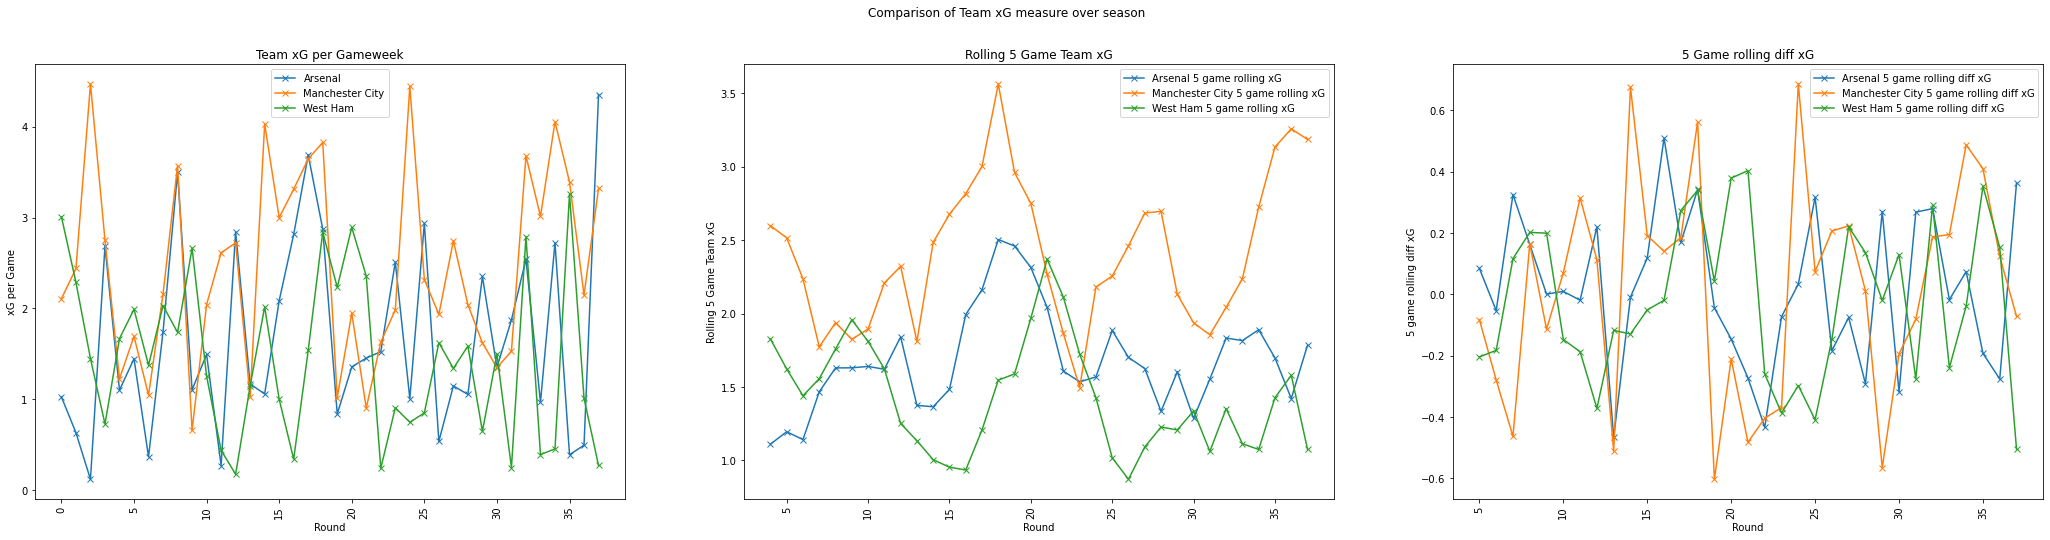

In [64]:
team_comparison('xG', 'Arsenal', 'Manchester City', 'West Ham')

From these three expected goals charts we can deduce the following:
- Arsenal attack started off very poorly and had a low score, however improved significantly towards the middle of the season and tailed off again towards end
- Man City had a very strong attack throughout season but especially potent around mid stage
- West Ham fluctuated a lot throughout the season

Review team performance for xGA over season

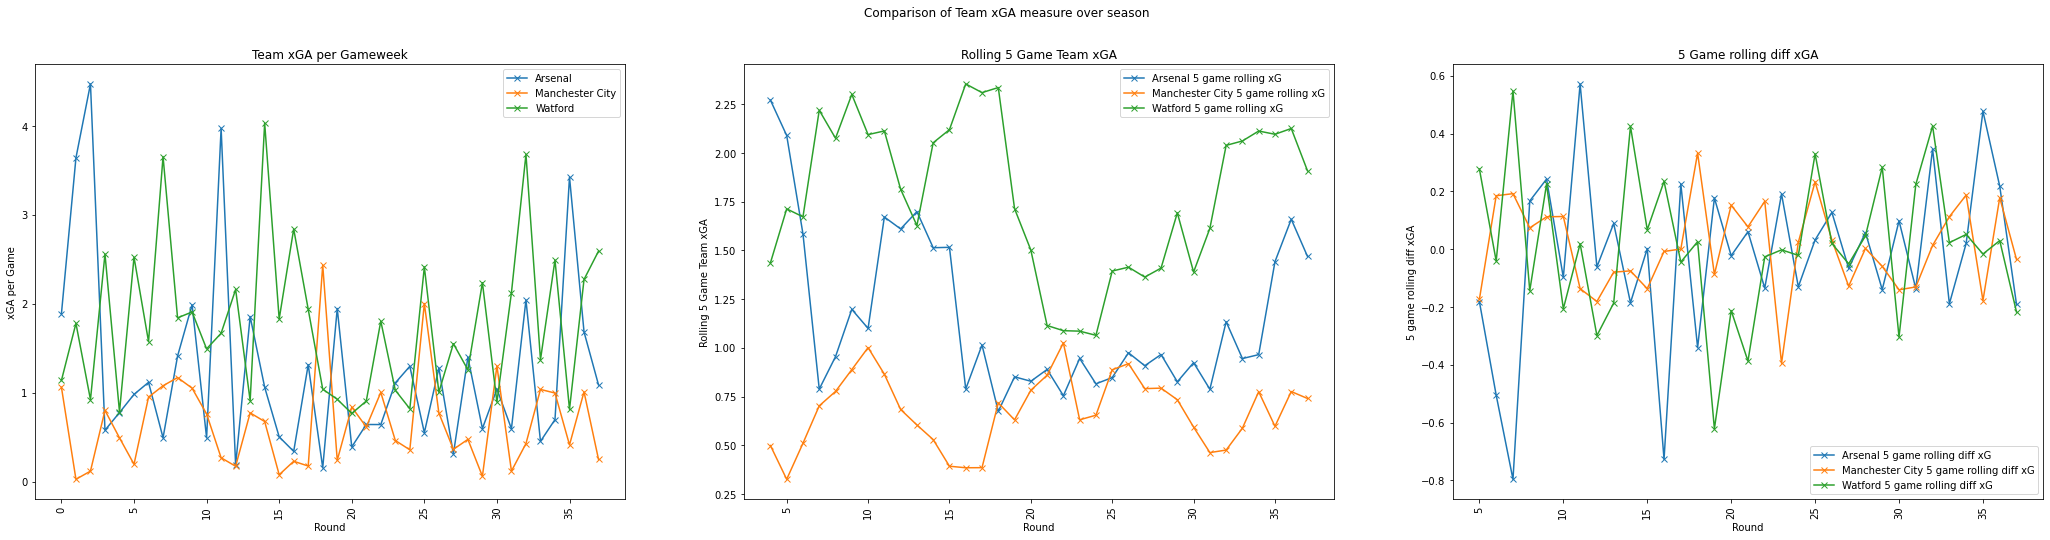

In [65]:
team_comparison('xGA', 'Arsenal', 'Manchester City', 'Watford')

From these three expected goals charts we can deduce the following:
- Arsenal defence started off very poorly conceding a lot of chances, however improved for most of the rest of the season
- Man City had a very strong defence throughout season
- Watford had a very poor defence throughout season however improved marginally around mid stage

What it is also clear from the above is that a 1 game consideration for a team's performance is a very noisy and difficult to interpret, however over a 5 game basis you can see the "trends" of a team. 

As the individual player performance is more important for this analysis it is easier to calculate a team "difficulty" measure for attack and defence to use.

*Add difficulty scores for teams def/attack*

The difficulty scores are considering all chances a team creates/scores (concedes chances/goals) plus a consideration for chances "missed".

In [66]:
# create new columns
df_teams.loc[:, 'attack_overall'] = df_teams['rolling_team_scored'] + df_teams['rolling_team_xG'] - df_teams['rolling_team_missed']
df_teams.loc[:, 'defence_overall'] = df_teams['rolling_team_conceded'] + df_teams['rolling_team_xGA']

Now to create an encoded version of this that reviews for each round a team's 5 game performance and rates it on scale of 1-5

In [67]:
# define function for attack score
def attack_score(x):
    if x >= eighty_a:
        return 5
    elif sixty_a <= x < eighty_a:
        return 4 
    elif fourty_a <= x < sixty_a:
        return 3
    elif twenty_a <= x < fourty_a:
        return 2
    elif x <= twenty_a:
        return 1

# define function for defence score    
def defence_score(x):
    if x >= eighty_d:
        return 1
    elif sixty_d <= x < eighty_d:
        return 2 
    elif fourty_d <= x < sixty_d:
        return 3
    elif twenty_d <= x < fourty_d:
        return 4
    elif x <= twenty_d:
        return 5    

summary = []

# iterate over each round of games
for x in df_teams['num_round'].unique():
    
    # create round summary 
    round_summary = df_teams[df_teams['num_round']==x].copy()
    
    # filter summary
    round_summary = round_summary[['team_name', 'date', 'attack_overall', 'defence_overall']]
    
    # define percentile values for each attack round 
    eighty_a = np.percentile(round_summary['attack_overall'], 80)
    sixty_a = np.percentile(round_summary['attack_overall'], 60)
    fourty_a = np.percentile(round_summary['attack_overall'], 40)
    twenty_a = np.percentile(round_summary['attack_overall'], 20)
    
    # define percentile values for each defence round 
    eighty_d = np.percentile(round_summary['defence_overall'], 80)
    sixty_d = np.percentile(round_summary['defence_overall'], 60)
    fourty_d = np.percentile(round_summary['defence_overall'], 40)
    twenty_d = np.percentile(round_summary['defence_overall'], 20)
    
    # apply functions to each overall score
    attack = round_summary['attack_overall'].apply(lambda x: attack_score(x))
    defence = round_summary['defence_overall'].apply(lambda x: defence_score(x))
    
    # build a new dataframe with these new values
    d = {
        "teams" : round_summary['team_name'].values,
        "round" : x,
        "attack_difficulty" : attack,
        "defence_difficulty": defence
        }
                
    round_summary = pd.DataFrame(d)
    
    # add to summary
    summary.append(round_summary)

Create a new dataframe to use in reference later

In [68]:
# combine summary 
dif_sum = pd.concat(summary)

# format dtype
dif_sum['round'] = dif_sum['round'].astype(int)

# organise teams
dif_sum = dif_sum.sort_values(by=['teams', 'round'])

# review
dif_sum

,teams,round,attack_difficulty,defence_difficulty
0,Arsenal,1,None,None
1,Arsenal,2,None,None
2,Arsenal,3,None,None
3,Arsenal,4,None,None
4,Arsenal,5,1,1
...,...,...,...,...
869,Wolverhampton Wanderers,35,1,1
870,Wolverhampton Wanderers,36,2,2
871,Wolverhampton Wanderers,36,1,1
872,Wolverhampton Wanderers,37,1,1


Map the values into the original dataset

In [69]:
df_teams['attack_difficulty'] = dif_sum['attack_difficulty'].values
df_teams['defence_difficulty'] = dif_sum['defence_difficulty'].values

In [70]:
# Drop columns used to build the difficulty scores
df_teams = df_teams.drop(['rolling_team_scored', 'rolling_team_conceded', 'rolling_team_xG', 'rolling_team_missed', 'rolling_team_xGA'], axis=1)

*Combine Player & Team databases*

In [71]:
# drop merge column from player database
df_all = df_all.drop('_merge', axis=1)
df_all.columns

Index(['assists', 'bonus', 'clean_sheets', 'fixture', 'goals_conceded',
       'goals_scored', 'kickoff_time', 'minutes', 'opponent_team', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves',
       'team_a_score', 'team_h_score', 'total_points', 'was_home',
       'yellow_cards', 'player_name_id_x', 'fpl_id', 'position', 'under_id',
       'date', 'shots', 'xG', 'time', 'h_team', 'a_team', 'h_goals', 'a_goals',
       'id', 'season', 'xA', 'key_passes', 'npg', 'npxG', 'xGChain',
       'xGBuildup', 'player_name_id_y', 'ustat_id', 'team_name', 'conceded',
       'teamname', 'num_round'],
      dtype='object')

In [72]:
# create new variable to add each player's data to
data = []

# iterate over each player, selecting subset of each player and mergine based on the date values
for x in df_all['ustat_id'].unique():
    
    # create subset
    player_df = df_all[df_all['ustat_id']==x]
    
    # find teamname for id
    team = player_df['team_name'].values[0]
    
    # filter team database by team
    team_df = df_teams[df_teams['team_name']==team]
        
    # merge with understat data
    merge = player_df.merge(team_df, left_on='date', right_on='date', how='left', indicator=True, suffixes=('', '_team'))  # add indicator to highlight any that havent worked on both
    
    # add merged data to new variables
    data.append(merge)

# build a new dataframe of all the merge datasets
df_new = pd.concat(data)

Verify shapes

In [73]:
print(df_all.shape)
print(df_new.shape)

(9899, 46)
(9899, 71)


Small dataset of values of "left_only"

In [74]:
# review names
df_new[df_new['_merge']=='left_only']['player_name_id_x'].unique()

array(['Bamidele_Alli_363', 'Calum_Chambers_10', 'Chris_Wood_109',
       'Daniel_James_287', 'Dan_Burn_58', 'Donny_van de Beek_282',
       'Lucas_Digne_168', 'Matt_Targett_39'], dtype=object)

These players all moved on loan during the season so conflicting data. Due to the size can remove from overall.

In [75]:
# create mask and remove
mask = df_new['_merge']=='left_only'
df_new = df_new[~mask]

In [76]:
# drop unnecessary columns
df_new = df_new.drop(['fixture', 'kickoff_time', 'time', 'id', 'season', 'player_name_id_y', 'team_name_team', '_merge', 'fpl_id', 'under_id', 'ustat_id'], axis=1)

In [77]:
# review
df_new.head()

,assists,bonus,clean_sheets,goals_conceded,goals_scored,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,team_a_score,team_h_score,total_points,was_home,yellow_cards,player_name_id_x,position,date,shots,xG,h_team,a_team,h_goals,a_goals,xA,key_passes,npg,npxG,xGChain,xGBuildup,team_name,conceded,teamname,num_round,h_a,xG_team,xGA,npxG_team,npxGA,scored,missed,result,pts,npxGD,conceded_team,num_round_team,rolling_team_pts,diff_team_xG,diff_team_xGA,diff_team_scored,diff_team_missed,diff_team_conceded,diff_team_pts,attack_overall,defence_overall,attack_difficulty,defence_difficulty
0,0.0,0.0,0.0,2.0,1.0,90.0,14,0.0,0.0,0.0,0.0,1,0.0,4.0,2.0,7.0,False,0.0,Aaron_Cresswell_411,def,2021-08-15,2.0,0.082975,Newcastle United,West Ham,2.0,4.0,0.037909,1.0,1.0,0.082975,0.544756,0.499803,West Ham,2.0,West Ham,1,a,3.009390,1.679260,2.092410,1.679260,4.0,2.0,w,3.0,0.413150,2.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
1,0.0,0.0,0.0,1.0,0.0,90.0,9,0.0,0.0,0.0,0.0,2,0.0,1.0,4.0,2.0,True,0.0,Aaron_Cresswell_411,def,2021-08-23,1.0,0.049394,West Ham,Leicester,4.0,1.0,0.000000,0.0,0.0,0.049394,0.223798,0.223798,West Ham,1.0,West Ham,2,h,2.286130,0.626760,2.286130,0.626760,4.0,1.0,w,3.0,1.659370,1.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
2,1.0,1.0,0.0,2.0,0.0,90.0,7,0.0,0.0,0.0,0.0,3,0.0,2.0,2.0,5.0,True,0.0,Aaron_Cresswell_411,def,2021-08-28,0.0,0.000000,West Ham,Crystal Palace,2.0,2.0,0.092539,1.0,0.0,0.000000,0.307552,0.215013,West Ham,2.0,West Ham,3,h,1.447480,1.676580,1.447480,1.676580,2.0,2.0,d,1.0,-0.229100,2.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
3,0.0,2.0,1.0,0.0,0.0,90.0,16,0.0,0.0,0.0,0.0,4,0.0,0.0,0.0,8.0,False,0.0,Aaron_Cresswell_411,def,2021-09-11,2.0,0.097969,Southampton,West Ham,0.0,0.0,0.024713,2.0,0.0,0.097969,0.164121,0.139408,West Ham,0.0,West Ham,4,a,0.725407,0.692135,0.725407,0.692135,0.0,0.0,d,1.0,0.033272,0.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
4,0.0,0.0,0.0,2.0,0.0,90.0,13,0.0,0.0,0.0,0.0,5,0.0,2.0,1.0,1.0,True,0.0,Aaron_Cresswell_411,def,2021-09-19,0.0,0.000000,West Ham,Manchester United,1.0,2.0,0.111972,2.0,0.0,0.000000,0.281568,0.169595,West Ham,2.0,West Ham,5,h,1.667100,1.895400,0.905935,1.895400,1.0,2.0,l,0.0,-0.989465,2.0,5,1.6,NaN,NaN,NaN,NaN,NaN,NaN,2.627101,2.714027,4,3


Convert opponent name with the id. Current logic is just based on alphabetical position in the table. 

In [78]:
# create alphabetical list of teams
teams = np.sort(df_new['team_name'].unique())

# the order for the iist of teams is not correctly alphabetical, neeed to switch leeds and leicester
teams[[8, 9]] = teams[[9, 8]]

# create range of 20 positions
idx = np.arange(1, 21)

# build a dictionary from both 
team_dict = dict(zip(idx, teams))

# change dtype pre map
df_new['opponent_team'] = df_new['opponent_team'].astype(int)

# apply to column in dataframe
df_new['opponent_team'] = df_new['opponent_team'].map(team_dict)

Assign opponent difficulties

In [79]:
# convert datatype
df_new['num_round_team'] = df_new['num_round_team'].astype(int)

oppo_attack = []
oppo_defence = []

for oppo, gameweek in zip(df_new['opponent_team'], df_new['num_round_team']):
    
    attack_difficulty = dif_sum.loc[(dif_sum['teams']==oppo) & (dif_sum['round'] == gameweek)]['attack_difficulty']
    defence_difficulty = dif_sum.loc[(dif_sum['teams']==oppo) & (dif_sum['round'] == gameweek)]['defence_difficulty']
    
    if attack_difficulty.empty:
        oppo_attack.append(None)
    
    else:
        oppo_attack.append(attack_difficulty.iloc[0])
        
    if defence_difficulty.empty:
        oppo_defence.append(None)
    
    else:
        oppo_defence.append(defence_difficulty.iloc[0])   

In [80]:
# create new columns
df_new['opposition_attack_difficulty'] = oppo_attack
df_new['opposition_defence_difficulty'] = oppo_defence

Drop unnecessary columns

In [81]:
df_new = df_new.drop(['team_a_score', 'team_h_score', 'was_home', 'h_team', 'a_team', 'h_goals', 'a_goals', 'result', 'teamname', 'num_round', 'num_round_team'], axis=1)

Create csv file to use in further analysis

In [82]:
df_new.to_csv('players_complete.csv', index=False)